In [8]:
from inception import Inception3
from torchvision import models
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import torch
from config import config
from data import class2set
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

import numpy as np
import cv2, os
from torch.utils.tensorboard import SummaryWriter

In [2]:
cfg = config('configs/dataconfig.yaml')
d = class2set(cfg, isTrain=False)
dl = DataLoader(d,batch_size=16,num_workers=4,shuffle=False)
device = torch.device('cuda')

pLabel:297 nLabel:753 prate:0.283


In [3]:
def getRestNet(weightPath):
    restnet = models.resnet50(pretrained=False)
    fc_features = restnet.fc.in_features
    restnet.fc = nn.Linear(fc_features, 2)
    restnetWeight = Path(weightPath)
    restnet.load_state_dict(torch.load(str(restnetWeight)))
    return restnet


def evalNet(net, dl, device):
    class_probs = []
    class_preds = []
    true_label = []
    dimages = []
    dlabels = []
    with torch.no_grad():
        net.to(device)
        for data in dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            dimages.append(inputs)
            dlabels.append(labels)
            output = net(inputs)
            class_probs_batch = [F.softmax(el, dim=0) for el in output]
            _, class_preds_batch = torch.max(output, 1)

            class_probs.append(class_probs_batch)
            class_preds.append(class_preds_batch)
            true_label.append(labels)

    test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    test_preds = torch.cat(class_preds)
    gt = torch.cat(true_label)
    return {'pred':test_preds, "prob":test_probs, "gt":gt}


def getPr(result):
    y_test = result['gt'].cpu().numpy()
    y_score = result['prob'][:,1].cpu().numpy()
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
    p,r,th = precision_recall_curve(y_test, y_score)
    return p,r,th


def getRoc(result):
    y_test = result['gt'].cpu().numpy()
    y_score = result['prob'][:,1].cpu().numpy()
    
    fpr, tpr, th = roc_curve(y_test, y_score)
    return fpr, tpr, th


def plotPr(res, colors, ls):
    plt.figure("P-R Curve")
    #plt.hold(True)
    plt.legend(loc='upper right')
    for re,c, l in zip(res, colors, ls):
        p,r,th,  = getPr(re)
        plt.title('Precision/Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot(r, p, color=c)
    plt.legend(ls)

    
def plotRoc(res, colors, ls):
    plt.figure("ROC Curve")
    #plt.hold(True)
    plt.legend(loc='upper right')
    for re,c, l in zip(res, colors, ls):
        fpr, tpr, th = getRoc(re)
        plt.title('Roc Curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.plot(fpr, tpr, color=c)
    plt.legend(ls)

    

In [39]:
balanceOnPreTrainOff = 'resnet/resnet50/balanceOnDataPreTrainOff/model_final.pth'
restNet_ = getRestNet(balanceOnPreTrainOff)
resultOnOff = evalNet(restNet_, dl, device)


In [40]:
balanceOnPreTrainOn = 'resnet/resnet50/balanceOnDataPreTrainOn/model_final.pth'
restNet_ = getRestNet(balanceOnPreTrainOn)
resultOnOn = evalNet(restNet_, dl, device)


In [41]:
balanceOffPreTrainOn = 'resnet/resnet50/balanceOffDataPreTrainOn/model_final.pth'
restNet_ = getRestNet(balanceOffPreTrainOn)
resultOffOn = evalNet(restNet_, dl, device)


In [107]:
ps[-2].data.cpu().numpy().shape

(2, 2048)

In [14]:
balanceOffPreTrainOn = 'resnet/resnet50/balanceOffDataPreTrainOn/model_final.pth'
restNet_ = getRestNet(balanceOffPreTrainOn)
features_blob = []
def hook_feature(model, infeature, outfeature):
    features_blob.append(outfeature.data.cpu().numpy())

In [12]:
def normCam(cam):
    cam = cam - np.min(cam)
    cam_image = cam / np.max(cam)
    cam_image = np.uint8(255*cam_image)
    return cv2.resize(cam_image, (512,512))


def getCAM(Net, dl, savePath):
    ps = list(restNet_.parameters())
    weight = ps[-2].data.cpu().numpy()
    
    features_blob = []
    def hook_feature(model, infeature, outfeature):
        features_blob.append(outfeature.data.cpu().numpy())
    Net._modules.get('layer4').register_forward_hook(hook_feature)
    
    imageId = 0
    healPath = savePath/Path('health')
    crackPath = savePath/Path('crack')
    
    os.makedirs(str(healPath))
    os.makedirs(str(crackPath))
    with torch.no_grad():
        for data in dl:
            features_blob.clear()
            inputs, labels = data[0], data[1]

            outputs = Net(inputs)
            outputs = F.softmax(outputs, dim=1).cpu().numpy()
            feature_conv =  features_blob[0]
            bz, nc, h, w = feature_conv.shape
            
            for bid, (im, out) in enumerate(zip(inputs.cpu().numpy(), outputs)):
                cam = weight.dot(feature_conv[bid].reshape(nc, h*w))
                im = im[0]
                healthyCam = cam[0].reshape(h, w)
                crackCam = cam[1].reshape(h,w)

                healthyCam = normCam(healthyCam)
                crackCam = normCam(crackCam)
                
                
                plt.imshow(im, cmap='gray')
                plt.imshow(crackCam, alpha=0.5, cmap='hot')  #alpha设置透明度, cmap可以选择颜色
                crackCamFile = Path(f'ImageCam{imageId}.jpg')
                plt.savefig(str(crackPath/crackCamFile))
                
                
                plt.imshow(im, cmap='gray')
                plt.imshow(healthyCam, alpha=0.2, cmap='hot')  #alpha设置透明度, cmap可以选择颜色
                healCamFile = Path(f'ImageCam{imageId}.jpg')
                plt.savefig(str(healPath/healCamFile))
                imageId += 1
                

In [13]:
savePath = Path('RestNetCam')
balanceOffPreTrainOn = 'resnet/resnet50/balanceOffDataPreTrainOn/model_final.pth'
restNet_ = getRestNet(balanceOffPreTrainOn)
getCAM(restNet_, dl, savePath)

FileExistsError: [Errno 17] File exists: 'RestNetCam/health'

In [15]:


restNet_._modules.get('layer4').register_forward_hook(hook_feature)

In [16]:
image = d[0][0]

In [17]:
image[0].numpy()

array([[161., 160., 158., ...,   5.,   4.,   4.],
       [161., 160., 158., ...,   6.,   5.,   4.],
       [160., 159., 158., ...,   6.,   5.,   5.],
       ...,
       [ 81.,  81.,  81., ...,  69.,  69.,  70.],
       [ 81.,  81.,  81., ...,  69.,  69.,  69.],
       [ 81.,  81.,  81., ...,  69.,  69.,  69.]], dtype=float32)

In [18]:
inImage = image.unsqueeze(0)

In [19]:
inImage.shape

torch.Size([1, 3, 512, 512])

In [20]:
out = restNet_(inImage)

In [21]:
out

tensor([[ 0.4927, -0.7832]], grad_fn=<AddmmBackward>)

In [22]:
h = F.softmax(out, dim=1).data.squeeze()

In [23]:
h

tensor([0.7818, 0.2182])

In [100]:
probs, idx = h.sort(0, True)

In [102]:
idx

tensor([0, 1])

In [24]:
ps = list(restNet_.parameters())
weight = ps[-2].data.cpu().numpy()

In [25]:
feature_conv =  features_blob[0]
bz, nc, h, w = feature_conv.shape

In [26]:
cam = weight.dot(feature_conv.reshape(nc, h*w))

In [27]:
healthyCam = cam[0].reshape(h, w)
crackCam = cam[1].reshape(h,w)

healthyCam = normCam(healthyCam)
crackCam = normCam(crackCam)

In [32]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [33]:
plt.imshow(crackCam, cmap='hot')

In [34]:
plt.imshow(image[0].numpy(), cmap='gray')
plt.imshow(crackCam, alpha=0.5, cmap='rainbow')  #alpha设置透明度, cmap可以选择颜色

In [144]:
plt.imshow(image[0].numpy(), cmap='gray')
plt.imshow(healthyCam, alpha=0.2, cmap='hot')  #alpha设置透明度, cmap可以选择颜色

In [131]:
plt.figure('original Image')
plt.imshow(image[0].numpy(), cmap='gray')

In [42]:
re = []
colors = ['r', 'g', 'b']
labels = []

# balance On  PreTrainOff

In [43]:
print(resultOnOff['pred'])
print(resultOnOff['gt'])
re.append(resultOnOff)
labels.append(f'B On Pre Off')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

# balance On PreTrainOn

In [44]:
print(resultOnOn['pred'])
print(resultOnOn['gt'])
re.append(resultOnOn)
labels.append(f'B On Pre On')

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

# balance Off PreTrainOn

In [45]:
print(resultOffOn['pred'])
print(resultOffOn['gt'])
re.append(resultOffOn)
labels.append(f'B Off Pre On')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

In [48]:
plotPr(re, colors, labels)

No handles with labels found to put in legend.


Average precision-recall score: 0.29
Average precision-recall score: 0.26
Average precision-recall score: 0.27


In [49]:
plotRoc(re, colors, labels)

No handles with labels found to put in legend.


In [49]:
%matplotlib

Using matplotlib backend: Qt5Agg


/home/zhenxing/code/tc


In [4]:
from AtNets import ATRestNet

In [5]:
resumePath = Path('ATresnetRPN/ATresnet/balanceOffDataPreTrainOn100ePoch/model_final.pth')

In [7]:
atnet = ATRestNet(resumePath=resumePath)

resume model from ATresnetRPN/ATresnet/balanceOffDataPreTrainOn100ePoch/model_final.pth


In [109]:
pred_At = []
inputImage = []
net = atnet
with torch.no_grad():
    net.to(device)
    for data in dl:
        inputs, labels = data[0].to(device), data[1].to(device)
        outmask = net(inputs)
        outmask = outmask.cpu()[:1]
        outmask = torch.softmax(outmask, dim=1)
        #outmask = torch.argmax(outmask, dim=1)
        #outmask_ = torch.ge(outmask, 0.45)
        #outmask_ = outmask_[:,1,:,:].repeat(1,3,1,1)
        #outmask = outmask.unsqueeze(1).repeat(1,3,1,1)
        
        
        pred_At.append(outmask)
        
        inputImage.append(inputs.cpu()[:1])


In [26]:
writer = SummaryWriter(str('jn_tflogs'))
writer.add_images('pred', pred_At, 0)
writer.add_images('images', inputImage, 0)

In [71]:
inputImage.shape

torch.Size([66, 3, 512, 512])

In [72]:
inputImage.shape

torch.Size([66, 3, 512, 512])

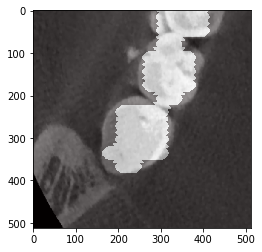

In [150]:
pred_At_ = torch.cat(pred_At)
inputImage_ = torch.cat(inputImage)
pred_At_ = torch.ge(pred_At_[:,1,:,:], 0.1)
pred_At_ = pred_At_.unsqueeze(1).repeat(1,3,1,1)

pred_show = pred_At_.permute(0,2,3,1)[:,:,:,0]
inputIm_show = inputImage_.permute(0,2,3,1)[:,:,:,0]

index = 1
mask1 = cv2.resize(pred_show[index].numpy().astype(np.uint8),(512,512))
oim = inputIm_show[index]
plt.imshow(oim, cmap='gray')
plt.imshow(mask1, cmap='hot', alpha=0.4)

In [111]:
pred_At_

tensor([[[[9.9999e-01, 1.0000e+00, 9.9989e-01,  ..., 1.2673e-01,
           9.9448e-01, 9.9265e-01],
          [1.0000e+00, 1.0000e+00, 9.9998e-01,  ..., 9.2495e-01,
           9.9704e-01, 9.5720e-01],
          [1.0000e+00, 1.0000e+00, 9.9964e-01,  ..., 9.9091e-01,
           9.9113e-01, 9.2087e-01],
          ...,
          [9.9998e-01, 1.0000e+00, 9.9998e-01,  ..., 1.0000e+00,
           1.0000e+00, 9.9996e-01],
          [9.9913e-01, 9.9999e-01, 9.9999e-01,  ..., 1.0000e+00,
           1.0000e+00, 9.9998e-01],
          [9.8127e-01, 9.9979e-01, 9.9996e-01,  ..., 1.0000e+00,
           1.0000e+00, 9.9936e-01]],

         [[5.1663e-06, 1.9081e-06, 1.0597e-04,  ..., 8.7327e-01,
           5.5187e-03, 7.3509e-03],
          [3.8709e-07, 9.6025e-08, 1.8100e-05,  ..., 7.5046e-02,
           2.9564e-03, 4.2800e-02],
          [4.6874e-06, 4.7892e-06, 3.6022e-04,  ..., 9.0860e-03,
           8.8714e-03, 7.9130e-02],
          ...,
          [2.1643e-05, 2.6974e-06, 2.4278e-05,  ..., 5.1274

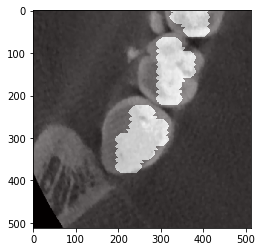

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)